In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from wordcloud import WordCloud
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# **Data Loading**
Menggunakan dua dataset, yaitu dataset lagu yang nantinya disebut dataset track dan riwayat lagu yang didengarkan disebut dataset user.
Dataset track berisi 114.000 baris dengan 20 kolom tentang detail informasi lagu seperti judul, artis, genre, tempo, dll. Sedangkan dataset user berisi 149.860 baris dan 11 kolom tentang riwayat lagu yang didengarkan lengkap dengan informasi seperti ID lagu, judul, durasi mendengarkan, dll.

Sumber dataset diperoleh dari website [Kaggle](https://kaggle.com/)
- [Dataset track](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset)
- [Dataset user](https://www.kaggle.com/datasets/sgoutami/spotify-streaming-history)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
track = pd.read_csv('/content/drive/My Drive/Dicoding ML Terapan/Kedua/spotify_songs.csv')
track.drop('Unnamed: 0', axis=1, inplace=True)
track.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [ ]:
track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           11

Penjelasan kolom-kolom dataset track

* track_id: ID lagu pada spotify
* artists: Artis yang menyanyikan lagu. Jika lebih dari satu dipisahkan dengan ";"
* album_name: Nama album dari lagu
* track_name: Judul lagu
* popularity : Nilai popularitas lagu dalam skala 0-100
* duration_ms: Durasi lagu dalam *milisecond*
* explicit: Penanda apakah lagu mengandung lirik eksplisit (kasar)
* danceability: Nilai kecocokan lagu digunakan untuk dansa, antara 0 dan 1. Semakin tinggi semakin cocok untuk berdansa
* energy: Nilai seberapa intens energi dalam lagu, antara 0 dan 1. Semakin tinggi semakin kuat dan bersemangat
* key: Nada dasar lagu, contoh 0=C, 1=C♯/D♭, dst.
* loudness: Nilai seberapa keras lagu dalam desibel (dB)
* mode: Tangga nada lagu, 1 untuk mayor, 0 untuk minor
* speechiness: Nilai seberapa banyak perkataan dalam lagu, antara 0 dan 1. Semakin tinggi menunjukkan banyak perkataan daripada nyanyian dalam lagu
* acousticness: Nilai seberapa akustik lagu, antara 0 dan 1
* instrumentalness: Nilai seberapa vokal dalam lagu, antara 0 dan 1. Semakin tinggi semakin tidak ada vokal
* liveness: Nilai adanya penonton dalam lagu, antara 0 dan 1. Semakin tinggi menunjukkan lagu dimainkan secara langsung (*live*)
* valence: Nilai emosi dalam lagu, antara 0 dan 1. Semakin tinggi nilai menunjukkan emosi lagu positif
* tempo: Jumlah ketukan (*beat*) lagu dalam *beats per minute* (BPM)
* time_signature: Tanda birama lagu
* track_genre: Genre lagu

In [ ]:
user = pd.read_csv('/content/drive/My Drive/Dicoding ML Terapan/Kedua/spotify_history.csv')
user.head()

,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
0,2J3n32GeLmMjwuAzyhcSNe,2013-07-08 02:44:34,web player,3185,"Say It, Just Say It",The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False
4,0GgAAB0ZMllFhbNc3mAodO,2013-07-08 03:17:52,web player,0,Half Mast,Empire Of The Sun,Walking On A Dream,clickrow,nextbtn,False,False


In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149860 entries, 0 to 149859
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   spotify_track_uri  149860 non-null  object
 1   ts                 149860 non-null  object
 2   platform           149860 non-null  object
 3   ms_played          149860 non-null  int64 
 4   track_name         149860 non-null  object
 5   artist_name        149860 non-null  object
 6   album_name         149860 non-null  object
 7   reason_start       149717 non-null  object
 8   reason_end         149743 non-null  object
 9   shuffle            149860 non-null  bool  
 10  skipped            149860 non-null  bool  
dtypes: bool(2), int64(1), object(8)
memory usage: 10.6+ MB


Penjelasan kolom-kolom dataset user

* spotify_track_uri: ID lagu pada spotify
* track_name: Judul lagu
* artist_name: Artis yang menyanyikan lagu
* album_name: Nama album dari lagu
* ts: Waktu ketika lagu selesai diputar, dalam format yyyy-MM-dd HH:mm:ss
* platform: Platfrom yang digunakan untuk mendengarkan lagu
* ms_played: Durasi putar lagu dalam *milisecond*
* reason_start: Alasan mulai memutar lagu
* shuffle: Penanda apakah lagu diputar dalam mode acak
* skipped: Penanda apakah lagu dilewati (*skip*) oleh pengguna

**Missing value**

Memeriksa jumlah data kosong pada kedua dataset. Data-data kosong ini akan dihilangkan.

In [ ]:
track_null = track.isnull().sum()
track_null[track_null > 0]

artists       1
album_name    1
track_name    1
dtype: int64

In [ ]:
user_null = user.isnull().sum()
user_null[user_null > 0]

reason_start    143
reason_end      117
dtype: int64

**Duplicate Value**

Pemeriksaan berapa banyak data duplikat pada kedua dataset. Data duplikat ini juga akan dihilangkan dari dataset

In [ ]:
print(f'{track.duplicated().sum()} data duplikat pada track')
print(f'{user.duplicated().sum()} data duplikat pada user')

450 data duplikat pada track
1185 data duplikat pada user


Proses menghapus data kosong dan duplikat pada dataset track dan user. Tersisa 113.549 baris pada datset track dan 148.463 baris pada dataset user.

In [ ]:
track.dropna(inplace=True)
track.drop_duplicates(inplace=True)
user.dropna(inplace=True)
user.drop_duplicates(inplace=True)
print(f'Track shape: {track.shape}, User shape: {user.shape}')

Track shape: (113549, 20), User shape: (148463, 11)


Memeriksa baris track dengan 'track_id' yang sama. Terdapat beberapa lagu yang memiliki ID duplikat.

In [ ]:
dup_id = track.duplicated(subset=['track_id'], keep=False)
dup_id.sum()

40108

Memeriksa salah satu lagu dengan ID  '5SuOikwiRyPMVoIQDJUgSV'. Ternyata dalam satu lagu bisa memiliki banyak genre

In [ ]:
idx_dup_id = dup_id[dup_id == True].index
df_dup = track.loc[idx_dup_id]
df_dup = df_dup[df_dup['track_id'] == '5SuOikwiRyPMVoIQDJUgSV']
df_dup[['track_id', 'artists', 'track_name', 'track_genre']]

,track_id,artists,track_name,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,acoustic
62102,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,j-pop
99152,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,singer-songwriter
102151,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,songwriter


Memeriksa jumlah data lagu pada dataset track dengan duplikasi pada beberapa kolom untuk mendeteksi lagu yang identik.

In [ ]:
dup_track = track.duplicated(subset=['artists', 'track_name', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'], keep=False)
dup_track.sum()

45132

Contoh pemeriksaan terhadap data lagu berjudul "I'm Yours". Terlihat bahwa data lagu dengan judul dan artis yang sama juga terduplikat dan memiliki ID yang berbeda.

In [ ]:
idx_dup_id = dup_track[dup_track == True].index
df_dup = track.loc[idx_dup_id]
df_dup = df_dup[df_dup['track_name'] == "I'm Yours"]
df_dup[['track_id', 'artists', 'track_name', 'track_genre']]

,track_id,artists,track_name,track_genre
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,I'm Yours,acoustic
20,3S0OXQeoh0w6AY8WQVckRW,Jason Mraz,I'm Yours,acoustic
91904,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,I'm Yours,rock


Menghilangkan data lagu yang identik berdasarkan kolom-kolom yang ditentukan. Proses ini menyisakan 83.908 baris pada dataset track.

In [ ]:
track_uniq = track.drop_duplicates(subset=['artists', 'track_name', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'])
track_uniq.shape

(83908, 20)

# **Exploratory Data Analysis**

Memilih sebagian baris saja dari dataset. Untuk dataset track hanya menggunakan lagu dengan nilai 'popularity' di atas 60. Sedangkan dataset user disaring hanya untuk ID lagu yang terdapat pada dataset track yang sudah disaring.

Proses ini menyisakan 9.488 baris pada dataset track dan 22.413 baris pada dataset user.

In [ ]:
track_uniq = track_uniq[track_uniq['popularity'] >= 60]
track_uniq.shape

(9488, 20)

In [ ]:
user_isin = user[user['spotify_track_uri'].isin(track_uniq['track_id'].values)]
user_isin = user_isin.rename(columns={'spotify_track_uri': 'track_id'})
user_isin.shape

(22413, 11)

Pemetaan genre dengan jumlah lagu terbanyak pada dataset track menggunakan Wordcloud dan diagram batang. Genre k-pop, pop-film dan hip-hop menjadi yang paling banyak.

In [ ]:
genres = track_uniq['track_genre'].value_counts()
genres.index

Index(['k-pop', 'pop-film', 'hip-hop', 'chill', 'alt-rock', 'edm', 'dance',
       'hard-rock', 'british', 'electro',
       ...
       'party', 'minimal-techno', 'ska', 'chicago-house', 'forro', 'mpb',
       'guitar', 'j-idol', 'samba', 'kids'],
      dtype='object', name='track_genre', length=102)

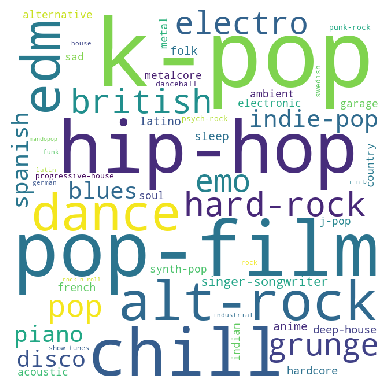

In [ ]:
cloud = WordCloud(
    width=640,
    height=640,
    background_color='white',
    min_font_size=10
).generate_from_frequencies(genres.to_dict())
plt.imshow(cloud, interpolation = 'nearest')
plt.axis('off')
plt.show()

<Axes: ylabel='track_genre'>

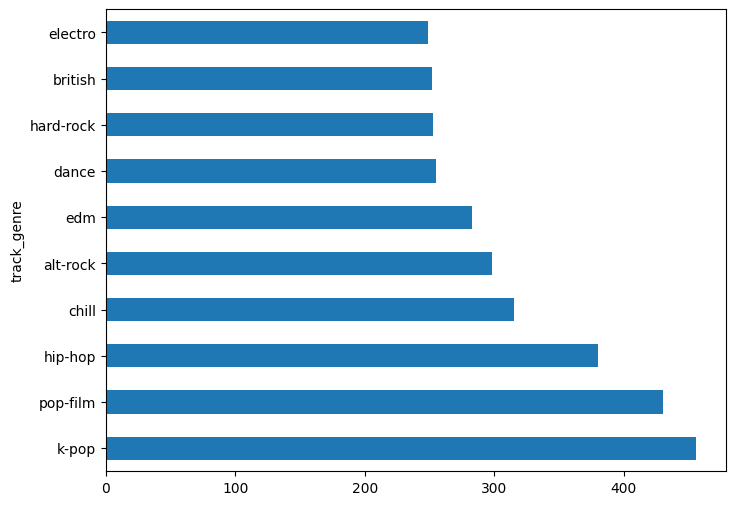

In [ ]:
genres[:10].plot(kind='barh', figsize=(8,6))

Analisis diagram batang genre yang paling sering didengarkan berdasarkan dataset user. Genre british cukup dominan dibanding genre lain.

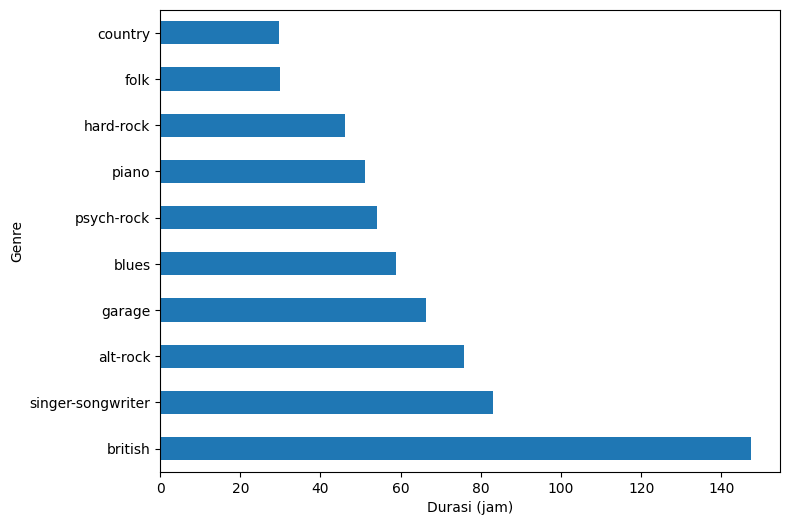

In [ ]:
track_merged = track_uniq.groupby('track_id')['track_genre'].agg(list).reset_index()
user_genres = pd.merge(user_isin, track_merged, on='track_id', how='left')
genres = Counter()
for i, row in user_genres.iterrows():
    for j in row['track_genre']:
        genres[j] += row['ms_played'] / (1e3 * 60 * 60)

user_genres_dur = pd.DataFrame.from_dict(genres, orient='index').reset_index()
user_genres_dur = user_genres_dur.rename(columns = {'index': 'genre', 0: 'ms_played'})
user_genres_dur.set_index('genre', inplace=True)
user_genres_dur = user_genres_dur.sort_values('ms_played', ascending=False)
user_genres_dur[:10].plot(kind='barh', figsize=(8,6))
plt.ylabel('Genre')
plt.xlabel('Durasi (jam)')
plt.legend().remove()
plt.show()

Analisis ditribusi data pada dataset track menggunakan histogram.

- Semakin tinggi popularitas, semakin sedikit jumlah lagu
- Dataset didominasi oleh lagu penuh nyanyian (speechiness rendah), bukan instrumental (instrumental rendah), bukan lagu akustik (acousticness rendah), serta tidak ditampilkan secara *live* (liveness rendah)
- Hampir seluruh lagu memiliki tanda birama 4/4 yang umum digunakan pada lagu pop. Hal ini bisa terjadi karena dataset track telah disaring menjadi hanya lagu-lagu populer
- Distribusi key hampir merata, dengan pengecualian nada dasar D# yang lebih kecil dari nada dasar lain
- Durasi lagu, valence, danceability, dinamika, serta tempo terdistribusi normal

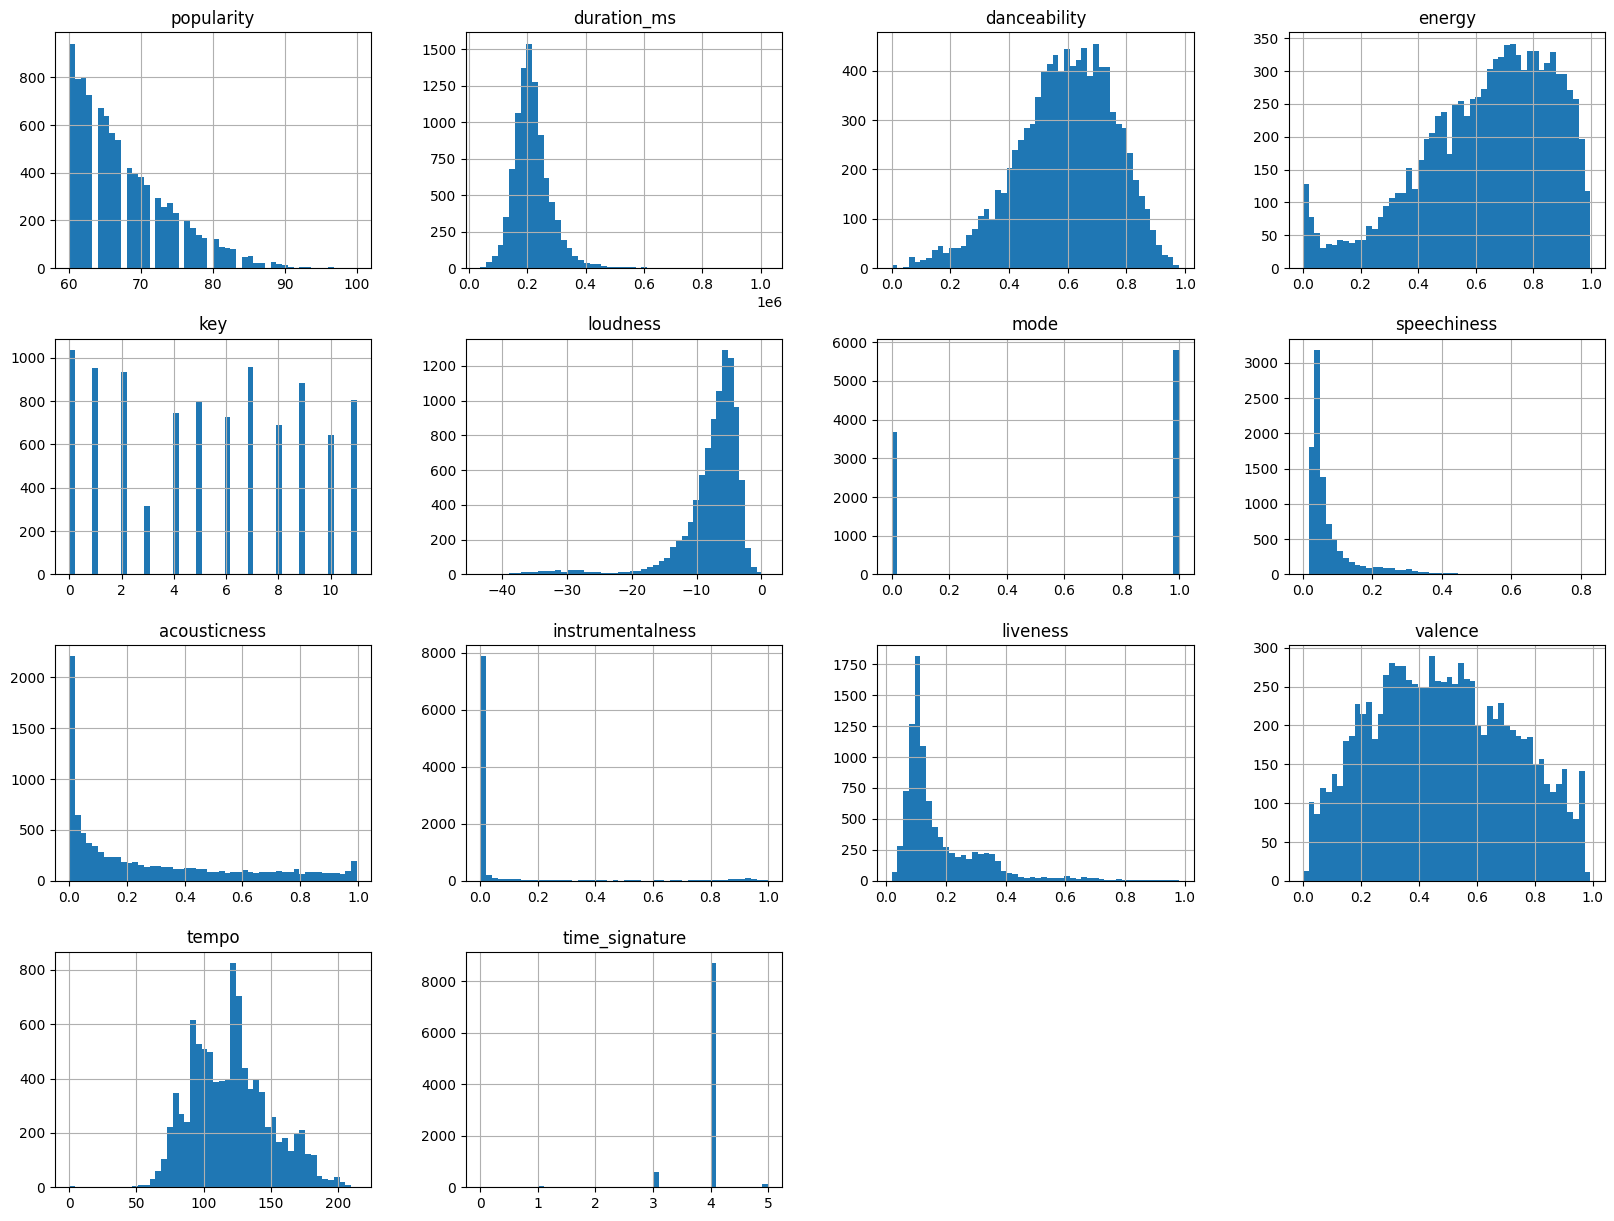

In [ ]:
track_uniq.hist(bins=50, figsize=(20,15))
plt.show()

# **Data Preparation**

**Formatting**

Menggabungkan data beberapa genre dalam satu lagu menjadi satu string

In [ ]:
track_merged = track.groupby('track_id')['track_genre'].agg(list).reset_index()
track_prep = track_uniq.drop('track_genre', axis=1)
track_prep = track_prep.merge(track_merged, on='track_id')
track_prep['track_genre'] = track_prep['track_genre'].apply(lambda x:' '.join(x))
track_prep['track_genre'] = [re.sub(r'-', '', t) for t in track_prep['track_genre']]

**Feature Engineering**

Membangun kolom 'content' untuk dataset track dari kolom 'speechiness', 'instrumentalness', 'tempo', 'mode', 'loudness', dan 'explicit'.

In [ ]:
def get_speech_content(row):
    speech = row['speechiness']
    return 'speech' if speech > 0.66 else 'music'

def get_instrumental_content(row):
    mode = row['instrumentalness']
    return 'instrumental' if mode > 0.85 else 'vocal'

def get_explicit_content(row):
    return 'explicit' if row['explicit'] else 'clean'

def get_mode_content(row):
    mode = row['mode']
    return 'major' if mode == 1 else 'minor'

def get_loudness_content(row):
    loudness = row['loudness']

    if loudness > -7:
        return 'stentorian'
    elif loudness > -11:
        return 'loud'
    elif loudness > -14:
        return 'normal'
    else:
        return 'quiet'

def get_tempo_content(row):
    tempo = row['tempo']

    if tempo < 40:
        return 'grave'
    elif tempo < 45:
        return 'lento'
    elif tempo < 55:
        return 'largo'
    elif tempo < 65:
        return 'adagio'
    elif tempo < 69:
        return 'adagietto'
    elif tempo < 77:
        return 'andante'
    elif tempo < 98:
        return 'moderato'
    elif tempo < 109:
        return 'allegretto'
    elif tempo < 132:
        return 'allegro'
    elif tempo < 140:
        return 'vivace'
    elif tempo < 177:
        return 'presto'
    else:
        return 'prestissimo'

In [ ]:
track_prep['content'] = track_prep.apply(get_speech_content, axis=1)
track_prep['content'] = track_prep['content'] + ' ' + track_prep.apply(get_instrumental_content, axis=1)
track_prep['content'] = track_prep['content'] + ' ' + track_prep.apply(get_tempo_content, axis=1)
track_prep['content'] = track_prep['content'] + ' ' + track_prep.apply(get_mode_content, axis=1)
track_prep['content'] = track_prep['content'] + ' ' + track_prep.apply(get_loudness_content, axis=1)
track_prep['content'] = track_prep['content'] + ' ' + track_prep.apply(get_explicit_content, axis=1)
track_prep['content'] = track_prep['content'] + ' ' + track_prep['track_genre']

In [ ]:
track_prep.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,content
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic jpop singersongwriter songwriter,music vocal moderato minor stentorian clean ac...
1,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,music vocal prestissimo major quiet clean acou...
2,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,music vocal allegro major loud clean acoustic
3,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,...,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic piano,music vocal presto major loud clean acoustic p...
4,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,...,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic rock,music vocal presto major loud clean acoustic rock


Membuat 180 ID pengguna secara acak pada dataset user

In [ ]:
def set_user_id(row):
    user_id = str(row['user_id'])
    rem_len = 5 - len(user_id)
    return f'U{"0" * rem_len}{user_id}'

In [ ]:
user_merged = pd.merge(user_isin, track_prep, on='track_id', how='inner')
user_merged['user_id'] = [random.randint(1, 180) for _ in range(len(user_merged))]
user_merged['user_id'] = user_merged.apply(set_user_id, axis=1)
user_merged.head()

,track_id,ts,platform,ms_played,track_name_x,artist_name,album_name_x,reason_start,reason_end,shuffle,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,content,user_id
0,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,...,0.0514,0.046900,0.000062,0.0525,0.530,128.062,4,progressivehouse,music vocal allegro minor stentorian clean pro...,U00180
1,1oHxIPqJyvAYHy0PVrDU98,2019-11-24 04:21:06,android,240327,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,trackdone,trackdone,True,...,0.0514,0.046900,0.000062,0.0525,0.530,128.062,4,progressivehouse,music vocal allegro minor stentorian clean pro...,U00152
2,4iG2gAwKXsOcijVaVXzRPW,2013-07-08 03:22:54,web player,1763,Time to Pretend,MGMT,Oracular Spectacular,clickrow,nextbtn,False,...,0.0452,0.000087,0.077700,0.3000,0.421,100.990,3,altrock,music vocal allegretto major stentorian explic...,U00128
3,4iG2gAwKXsOcijVaVXzRPW,2016-11-29 02:01:07,android,2959,Time to Pretend,MGMT,Oracular Spectacular,fwdbtn,fwdbtn,True,...,0.0452,0.000087,0.077700,0.3000,0.421,100.990,3,altrock,music vocal allegretto major stentorian explic...,U00120
4,4iG2gAwKXsOcijVaVXzRPW,2017-01-09 16:59:17,android,1555,Time to Pretend,MGMT,Oracular Spectacular,fwdbtn,fwdbtn,True,...,0.0452,0.000087,0.077700,0.3000,0.421,100.990,3,altrock,music vocal allegretto major stentorian explic...,U00063


**Data Merging**

Akumulasi durasi mendengarkan dengan ID pengguna dan ID lagu yang sama

In [ ]:
user_merged.duplicated(subset=['track_id', 'user_id']).sum()

2951

In [ ]:
user_prep = user_merged.groupby(['track_id', 'user_id'])['ms_played'].agg(sum).reset_index()
user_prep.shape

(19462, 3)

In [ ]:
user_prep = user_merged[['track_id', 'user_id', 'ms_played']]
user_prep.head()

,track_id,user_id,ms_played
0,1oHxIPqJyvAYHy0PVrDU98,U00180,61865
1,1oHxIPqJyvAYHy0PVrDU98,U00152,240327
2,4iG2gAwKXsOcijVaVXzRPW,U00128,1763
3,4iG2gAwKXsOcijVaVXzRPW,U00120,2959
4,4iG2gAwKXsOcijVaVXzRPW,U00063,1555


**Encoding**

Mengubah ID user dan ID lagu pada dataset user ke dalam urutan angka dari 1 hingga jumlah ID yang ada, yaitu 180.

In [ ]:
user_ids = user_prep['user_id'].unique().tolist()
user_to_code = {x: i for i, x in enumerate(user_ids)}
code_to_user = {i: x for i, x in enumerate(user_ids)}

track_ids = user_prep['track_id'].unique().tolist()
track_to_code = {x: i for i, x in enumerate(track_ids)}
code_to_track = {i: x for i, x in enumerate(track_ids)}

**Scaling**

Mengubah semua nilai 'ms_played' pada dataset user dalam skala antara 0 dan 1

In [ ]:
user_prep['user'] = user_prep['user_id'].map(user_to_code)
user_prep['track'] = user_prep['track_id'].map(track_to_code)
user_prep['ms_played'] = user_prep['ms_played'].values.astype(np.float32)
user_prep = user_prep.sample(frac=1, random_state=42)
user_prep.head()

C:\Users\Nitro\AppData\Local\Temp\ipykernel_8848\1967737198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_prep['user'] = user_prep['user_id'].map(user_to_code)
C:\Users\Nitro\AppData\Local\Temp\ipykernel_8848\1967737198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_prep['track'] = user_prep['track_id'].map(track_to_code)
C:\Users\Nitro\AppData\Local\Temp\ipykernel_8848\1967737198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

,track_id,user_id,ms_played,user,track
11131,5FPnjikbwlDMULCCCa6ZCJ,U00001,2142.0,62,343
20478,714hERk9U1W8FMYkoC83CO,U00088,244920.0,78,828
19230,6PwjJ58I4t7Mae9xfZ9l9v,U00152,197200.0,1,706
3794,4F1AgKpuFRMLEgtPETVwZk,U00149,129120.0,31,158
134,4LloVtxNZpeh7q7xdi1DQc,U00121,263573.0,85,5


**Train-test Split**

Dataset user dibagi menjadi data training dan validation dengan proporsi 80:20.

In [ ]:
min_ms = min(user_prep['ms_played'])
max_ms = max(user_prep['ms_played'])

x = user_prep[['user', 'track']].values
y = user_prep['ms_played'].apply(lambda x: (x - min_ms) / (max_ms - min_ms)).values
train_indices = int(0.8 * user_prep.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

# **Model Development**

**Cosine Similarity**

Membangun model rekomendasi *content-based filtering* yang memberikan rekomendasi berdasarkan konten dari item yang diinputkan

In [ ]:
tf_idf = TfidfVectorizer()
tf_idf.fit(track_prep['content'])
tf_idf.get_feature_names_out()

array(['acoustic', 'adagietto', 'adagio', 'afrobeat', 'allegretto',
       'allegro', 'alternative', 'altrock', 'ambient', 'andante', 'anime',
       'bluegrass', 'blues', 'brazil', 'breakbeat', 'british', 'cantopop',
       'chicagohouse', 'children', 'chill', 'classical', 'clean', 'club',
       'comedy', 'country', 'dance', 'dancehall', 'deathmetal',
       'deephouse', 'disco', 'disney', 'drumandbass', 'dub', 'dubstep',
       'edm', 'electro', 'electronic', 'emo', 'explicit', 'folk', 'forro',
       'french', 'funk', 'garage', 'german', 'gospel', 'goth', 'grave',
       'groove', 'grunge', 'guitar', 'happy', 'hardcore', 'hardrock',
       'hardstyle', 'heavymetal', 'hiphop', 'house', 'idm', 'indian',
       'indie', 'indiepop', 'industrial', 'instrumental', 'jazz',
       'jdance', 'jidol', 'jpop', 'jrock', 'kids', 'kpop', 'largo',
       'latin', 'latino', 'loud', 'major', 'malay', 'mandopop', 'metal',
       'metalcore', 'minimaltechno', 'minor', 'moderato', 'mpb', 'music',
    

In [ ]:
tfidf_matrix = tf_idf.fit_transform(track_prep['content'])
tfidf_matrix = tfidf_matrix.astype(np.float32)
tfidf_matrix.shape

(9488, 129)

In [ ]:
tfidf_matrix.todense()

matrix([[0.5186882 , 0.        , 0.        , ..., 0.        , 0.09963802,
         0.        ],
        [0.6653519 , 0.        , 0.        , ..., 0.        , 0.12781157,
         0.        ],
        [0.81078684, 0.        , 0.        , ..., 0.        , 0.15574904,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.13547343,
         0.8401045 ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.13845068,
         0.85856724],
        [0.        , 0.        , 0.        , ..., 0.        , 0.12393811,
         0.76857114]], dtype=float32)

In [ ]:
df_tfidf = pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf_idf.get_feature_names_out(),
    index=track_prep['track_name']
)
df_tfidf.sample(10, axis=1).sample(10, axis=0)

,hardcore,songwriter,sad,quiet,club,rocknroll,loud,forro,jrock,afrobeat
track_name,,,,,,,,,,
Bijlee Bijlee,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
grace,0.0,0.0,0.0,0.000000,0.0,0.000000,0.339952,0.0,0.0,0.0
Shimmering Above Clouds,0.0,0.0,0.0,0.368257,0.0,0.000000,0.000000,0.0,0.0,0.0
We Will Rock You - Remastered 2011,0.0,0.0,0.0,0.000000,0.0,0.000000,0.351731,0.0,0.0,0.0
BABY OTAKU,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
State Lines,0.0,0.0,0.0,0.000000,0.0,0.000000,0.208828,0.0,0.0,0.0
@ my worst,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
idfc,0.0,0.0,0.0,0.000000,0.0,0.000000,0.296100,0.0,0.0,0.0
"You've Lost That Loving Feeling - Live at The International Hotel, Las Vegas",0.0,0.0,0.0,0.000000,0.0,0.591014,0.000000,0.0,0.0,0.0


In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=track_prep['track_id'], columns=track_prep['track_id'])
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9488, 9488)


track_id,57uX2vR9j9DNiANDYfXw1i,4F3AZKEJubvPsl0hBArVBW,3Y6XWs8xMlCngyIxNOFnsp,4dSoDnmR9opAQ8KxUc9SbC,31AOj9sFz2gM0O3hMARRBx
track_id,,,,,
2k5SEAK05D29ZkqbnFgIVL,0.078048,0.116079,0.072298,0.068864,0.172471
6Q5uDNuuFYa8ToL3CCoHPC,0.089923,0.017093,0.083298,0.079342,0.088155
5HcBFhFQEtqKrsRkr95XYu,0.250808,0.121822,0.161478,0.221297,0.207408
5qhWIOZ6HztbHnsWNnkJTf,0.084799,0.126120,0.193691,0.074821,0.187390
0BAsf69u0gltlMFYMADpAn,0.250938,0.142341,0.062388,0.102534,0.120520
0GQngE2rOYvlKwEQjTAsP8,0.206878,0.247909,0.291405,0.182535,0.094706
6Fnvi5QnVkTskSzeRvvQds,0.163126,0.199810,0.087576,0.368347,0.169179
04VUjNx30IrigVZU3CQmrQ,0.165916,0.366232,0.264005,0.146394,0.172072
5EugXICXL06waHgP4iTI58,0.072186,0.107361,0.164882,0.235043,0.096125


In [ ]:
def recommendations(track_id, similarity_data=cosine_sim_df, items=track_prep, k=5):
    sim = similarity_data.loc[:, track_id].to_numpy()
    idx_range = range(-1, -k, -1)
    index = sim.argpartition(idx_range)
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    scores =  sim[index[-1:-(k+2):-1]]

    df_closest = pd.DataFrame(closest).merge(items, on='track_id')
    df_closest = df_closest[['track_id', 'artists', 'track_name', 'content']]

    df_closest['score'] = scores
    df_closest.set_index('track_id', inplace=True)
    df_closest.drop(track_id, errors='ignore', inplace=True)
    df_closest.sort_values('score', ascending=False, inplace=True)
    return df_closest.head()

Percobaan sistem *content-based filtering* dengan ID lagu '10rChmECwPcvTTj4w07hq4'.

In [ ]:
track_prep[track_prep['track_id'] == '10rChmECwPcvTTj4w07hq4']

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,content
7953,10rChmECwPcvTTj4w07hq4,Simple Plan,Still Not Getting Any,Welcome to My Life,69,206773,False,0.421,0.858,1,...,1,0.0963,0.0134,0.0,0.067,0.491,173.255,4,punkrock punk,music vocal presto major stentorian clean punk...


Hasil rekomendasi content-based filtering yang menampilkan 5 lagu serupa dengan lagu ID '10rChmECwPcvTTj4w07hq4'

In [ ]:
cb_rec = recommendations('10rChmECwPcvTTj4w07hq4')
cb_rec

,artists,track_name,content,score
track_id,,,,
7sziTn5nHwrWf4K7gISaaU,Simple Plan;Sean Paul,Summer Paradise (feat. Sean Paul) - Single Ver...,music vocal presto major stentorian clean punk...,1.0
371Tb0eNfpjpSqggjcLv8c,All Time Low,Therapy,music vocal presto major stentorian clean punk...,1.0
2m1hi0nfMR9vdGC8UcrnwU,blink-182,All The Small Things,music vocal presto major stentorian clean punk...,1.0
4NnWuGQujzWUEg0uZokO5M,The Cure,Just Like Heaven,music vocal presto major stentorian clean punk...,1.0
0I329vpTJRdSRjEcWaQsSL,Simple Plan;Natasha Bedingfield,Jet Lag (feat. Natasha Bedingfield),music vocal presto major stentorian clean punk...,1.0


**Dot Product**

Membangun model rekomendasi *collaborative filtering* yang memberikan rekomendasi berdasarkan kemiripan item dengan pengguna lainnya

In [ ]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_tracks, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_tracks = num_tracks
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.track_embedding = layers.Embedding(
            num_tracks,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.track_bias = layers.Embedding(num_tracks, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])
        user_bias = self.user_bias(inputs[:, 0])
        track_vector = self.track_embedding(inputs[:, 1])
        track_bias = self.track_bias(inputs[:, 1])

        dot_user_track = tf.tensordot(user_vector, track_vector, 2)
        x = dot_user_track + user_bias + track_bias
        return tf.nn.sigmoid(x)

In [ ]:
num_users = len(user_to_code)
num_tracks = len(track_to_code)

model = RecommenderNet(num_users, num_tracks, 50)
model.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 10,
    validation_data = (x_val, y_val)
)

Epoch 1/10
2242/2242 [==============================] - 6s 2ms/step - loss: 0.5236 - root_mean_squared_error: 0.2626 - val_loss: 0.3955 - val_root_mean_squared_error: 0.1196
Epoch 2/10
2242/2242 [==============================] - 4s 2ms/step - loss: 0.3901 - root_mean_squared_error: 0.1132 - val_loss: 0.3945 - val_root_mean_squared_error: 0.1191
Epoch 3/10
2242/2242 [==============================] - 4s 2ms/step - loss: 0.3867 - root_mean_squared_error: 0.1096 - val_loss: 0.3935 - val_root_mean_squared_error: 0.1187
Epoch 4/10
2242/2242 [==============================] - 3s 1ms/step - loss: 0.3846 - root_mean_squared_error: 0.1073 - val_loss: 0.3918 - val_root_mean_squared_error: 0.1169
Epoch 5/10
2242/2242 [==============================] - 3s 1ms/step - loss: 0.3832 - root_mean_squared_error: 0.1058 - val_loss: 0.3905 - val_root_mean_squared_error: 0.1155
Epoch 6/10
2242/2242 [==============================] - 3s 1ms/step - loss: 0.3822 - root_mean_squared_error: 0.1047 - val_loss: 0

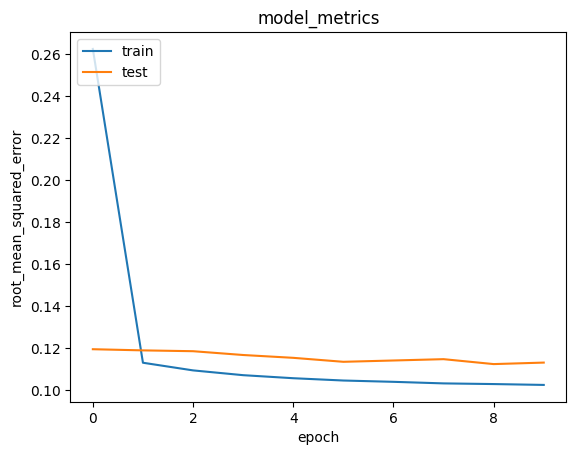

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Pengujian model *collaborative filtering* untuk pengguna dengan ID 'U00007'

In [ ]:
def get_user_tracks(id):
    user_track = user_merged[user_merged['user_id'] == id]
    user_track = user_track.sort_values('ms_played', ascending=False)
    return user_track[['track_id', 'artists', 'track_name_x', 'track_genre', 'ms_played']]

Menampilkan riwayat lagu yang didengarkan oleh pengguna

In [ ]:
user_track = get_user_tracks('U00007')
user_track.head()

,track_id,artists,track_name_x,track_genre,ms_played
11608,5hhVpGIBlqAU5yJEOmrk5o,Led Zeppelin,All My Love - Remaster,hardrock,353720
18816,1BLOVHYYlH4JUHQGcpt75R,The Strokes,Ode To The Mets,altrock garage,351786
8669,70C4NyhjD5OZUMzvWZ3njJ,Billy Joel,Piano Man,folk piano singersongwriter songwriter,339000
15395,78WVLOP9pN0G3gRLFy1rAa,Billy Joel,Piano Man,piano,336200
4840,2oaK4JLVnmRGIO9ytBE1bt,Red Hot Chili Peppers,Dark Necessities,altrock alternative funk metal,302000


Pemetaan genre yang paling lama didengar oleh pengguna

In [ ]:
user_genres = Counter()
for i, row in user_track.iterrows():
    for j in row['track_genre'].split(' '):
        user_genres[j] += row['ms_played']

user_genres_ms = pd.DataFrame.from_dict(user_genres, orient='index').reset_index()
user_genres_ms = user_genres_ms.rename(columns = {'index': 'genre', 0: 'ms_played'})
user_genres_ms.set_index('genre', inplace=True)
user_genres_ms = user_genres_ms.sort_values('ms_played', ascending=False)
user_genres_ms[:5]

,ms_played
genre,
psychrock,2728243
singersongwriter,2011089
songwriter,2011089
rock,1975291
british,1958405


Hasil rekomendasi *collaborative filtering* untuk pengguna ID 'U00007'

In [ ]:
user_id = 'U00007'
user_history = user_prep[user_prep['user_id'] == user_id]
track_not_listened = track_prep[~track_prep['track_id'].isin(user_history['track_id'].values)]['track_id']
track_not_listened = list(set(track_not_listened).intersection(set(track_to_code.keys())))
track_code_not_listened = [[track_to_code.get(x)] for x in track_not_listened]

user_code = user_to_code.get(user_id)
user_track_array = np.hstack(
    ([[user_code]] * len(track_code_not_listened), track_code_not_listened)
)

In [ ]:
pred_ms = model.predict(user_track_array).flatten()
pred_ms_indices = pred_ms.argsort()[-5:][::-1]
rec_track_ids = [
    code_to_track.get(track_code_not_listened[x][0]) for x in pred_ms_indices
]

rec_user_track = track_prep[track_prep['track_id'].isin(rec_track_ids)]
rec_user_track[['track_id', 'artists', 'track_name', 'track_genre']]

35/35 [==============================] - 0s 974us/step


,track_id,artists,track_name,track_genre
820,3qiyyUfYe7CRYLucrPmulD,The Who,Baba O'Riley,blues british hardrock psychrock
1105,1Ud6moTC0KyXMq1Oxfien0,The Rolling Stones,Sympathy For The Devil - 50th Anniversary Edition,british
6341,2ksOAxtIxY8yElEWw8RhgK,Anuel AA;Daddy Yankee;KAROL G;J Balvin;Ozuna,China,latino reggae reggaeton
7870,5p3JunprHCxClJjOmcLV8G,Lou Reed,Walk On the Wild Side,psychrock
8624,5gbxzSqABThINGDb7vIiwe,John Mayer,Edge of Desire,singersongwriter songwriter


# **Model Evaluation**

Evaluasi model *content-based filtering* dengan metrik Precision at K dengan hasil **1.0**

In [ ]:
cb_track = track_prep[track_prep['track_id'] == '10rChmECwPcvTTj4w07hq4']
cb_track_content = cb_track['content'].values[0]
cb_relevant = cb_rec[cb_rec['content'] == cb_track_content]
print(f"Precision at 5: {len(cb_relevant)/5}")

Precision at 5: 1.0


Evaluasi model *collaborative filtering* dengan metrik Root Mean Squared Error (RMSE) dengan hasil **177.973,790** ms (≈3 menit).

In [ ]:
pred_val = model.predict(x_val).flatten()
mse_val = mean_squared_error(y_true=y_val, y_pred=pred_val)
scaled_rmse_val = np.sqrt(mse_val)
rmse_val = (scaled_rmse_val * (max_ms - min_ms)) + min_ms
rmse_val= '{0:.3f}'.format(rmse_val)
print(f"RMSE: {rmse_val}")

141/141 [==============================] - 0s 1ms/step
RMSE: 177973.790
